In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


### Masked

In [2]:
loader_path = "./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt"
model       = torch.load(
                   "./results/trained_models/Masked_Phe/Model_GIN_classifier_to_explain_v2_06-11-2022_19h_12min_best_ValAcc_0.9200301772915881_epoch_83.pt")

loader       = torch.load(loader_path)
loader_train = loader.get_train_loader()
explainer    = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
model.to(device, non_blocking=True)


model.eval()
gc.collect()
torch.cuda.empty_cache() 
edge_num           = loader_train.dataset[0].edge_index.shape[1]
all_graphs_weights = []#torch.empty(edge_num,1).to(device)

for graph in loader_train.dataset:
    _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
    
    all_graphs_weights.append(edge_weights.reshape(edge_num,1))

Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 564.14it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

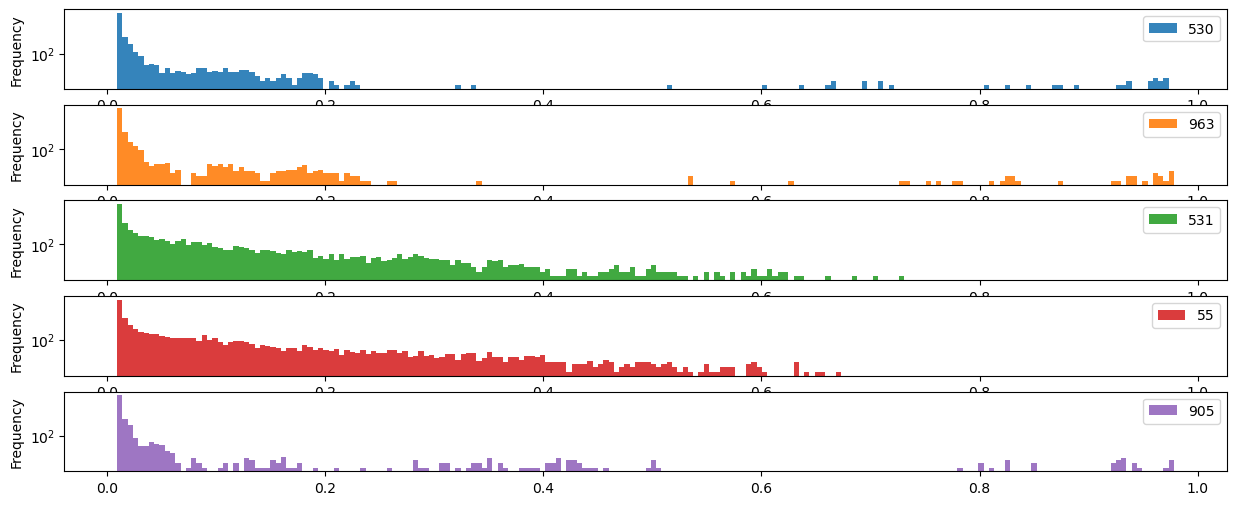

In [3]:
import numpy as np
all_graphs_weights_df = pd.DataFrame(
torch.stack(all_graphs_weights,1).squeeze().cpu().numpy())



all_graphs_weights_df.loc[:,np.random.randint(1, 1000, 5)].plot.hist(bins=200, alpha=0.9, figsize=(15,6), subplots=True, sharey=False, 
                      sharex=False, logy = True, ylabel = ['', '', ''], grid=False)


In [4]:
train_labels = []
for graph in tqdm.tqdm(loader_train.dataset):
    train_labels.append(graph.y.cpu().item())
assert train_labels.__len__() == all_graphs_weights_df.shape[1]
#all_graphs_weights.shape

labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
labels
pd.Series(labels).to_csv("./results/dataframes/Masked_train_labels.csv")

all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]
print(f"{all_graphs_weights_df.shape=}")
all_graphs_weights_df.to_parquet('./results/dataframes/Masked_graphs_weights_from_explainer.parquet.gzip', compression = 'gzip')

100%|██████████| 4921/4921 [00:00<00:00, 748103.30it/s]


all_graphs_weights_df.shape=(38428, 4921)


### Process explainer weights

((385, 4921), (38428,))

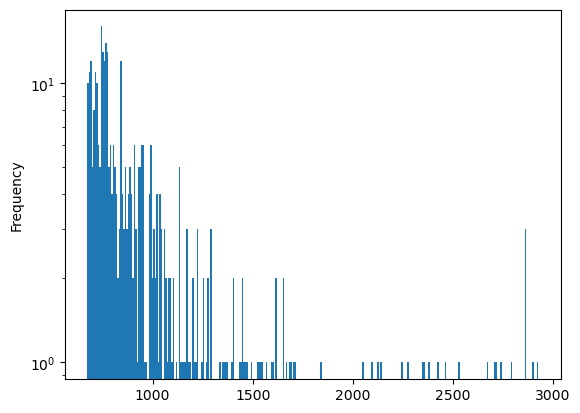

In [5]:
edge_mask = all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 99)


filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]

filtered_graph_weights_df.sum(axis=1).plot.hist(logy = True, bins=300)
filtered_graph_weights_df.shape, edge_mask.shape

<AxesSubplot:ylabel='Frequency'>

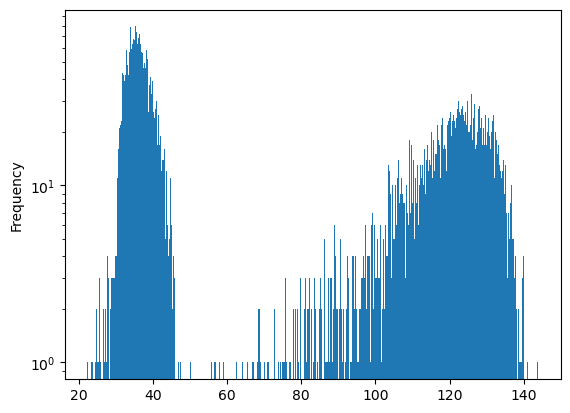

In [6]:
filtered_graph_weights_df.sum(axis=0).plot.hist(logy = True, bins=500)


In [7]:
filtered_graph_weights = filtered_graph_weights_df.transpose() 
filtered_graph_weights["Label"] = list(labels)

filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights

,8,59,940,1477,1554,1557,1575,1596,1605,1763,...,38112,38113,38115,38116,38118,38120,38121,38122,38171,Label
0,0.263610,0.500152,0.022213,0.013658,0.044910,0.044804,0.041946,0.089218,0.065395,0.356812,...,0.357962,0.343592,0.350410,0.355480,0.342187,0.203736,0.494993,0.346614,0.133351,Control
1,0.013635,0.013634,0.013784,0.014185,0.140470,0.232167,0.138713,0.013788,0.013685,0.013857,...,0.021220,0.014216,0.013552,0.015447,0.014052,0.013731,0.013670,0.023622,0.013741,PKU
2,0.255285,0.511573,0.174154,0.565478,0.269273,0.267312,0.269733,0.210430,0.209697,0.294695,...,0.111294,0.079315,0.267988,0.098388,0.110080,0.393837,0.160197,0.119780,0.250750,Control
3,0.013854,0.013680,0.013734,0.014103,0.093496,0.140359,0.084104,0.013769,0.013807,0.013956,...,0.974709,0.186100,0.013789,0.967487,0.920189,0.013662,0.014753,0.973370,0.013885,PKU
4,0.292490,0.614619,0.358388,0.488262,0.032427,0.031702,0.028457,0.199029,0.211669,0.426691,...,0.159137,0.126603,0.429557,0.147770,0.145110,0.446415,0.373386,0.154909,0.239337,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4916,0.294427,0.595013,0.490835,0.470971,0.061514,0.059736,0.054562,0.293746,0.292234,0.381139,...,0.301151,0.244175,0.401863,0.289766,0.251329,0.340212,0.431346,0.307636,0.245641,Control
4917,0.321659,0.602163,0.379571,0.578085,0.067508,0.066362,0.059136,0.207643,0.199995,0.402672,...,0.217874,0.153749,0.459757,0.201004,0.195160,0.348344,0.376282,0.210369,0.319365,Control
4918,0.238522,0.639294,0.433610,0.562015,0.074055,0.073548,0.064436,0.352196,0.361649,0.403224,...,0.262969,0.226245,0.483685,0.256792,0.238165,0.448906,0.367636,0.258740,0.298710,Control
4919,0.013877,0.013622,0.013769,0.014133,0.034199,0.035082,0.034179,0.013933,0.013899,0.013910,...,0.050405,0.018634,0.013627,0.037119,0.022755,0.013639,0.014157,0.043224,0.013712,PKU


In [8]:
PYG_graph = torch.load("./results/graphs/PYG_graph_Concen_plus_Fluxes.pt")
NX_graph  = nx.read_gpickle("./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")
edge_0_node_idxs =  PYG_graph.edge_index[0,:]
edge_1_node_idxs =  PYG_graph.edge_index[1,:]
edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]

edges_node_names_explainer_subgraphs

,node1,node2,0,1,2,3,4,5,6,7,...,4911,4912,4913,4914,4915,4916,4917,4918,4919,4920
8,GTHO,gthrd_c,0.263610,0.013635,0.255285,0.013854,0.292490,0.013644,0.291774,0.323335,...,0.013862,0.280309,0.264044,0.284307,0.156630,0.294427,0.321659,0.238522,0.013877,0.013732
59,ACACT1rm,coa_m,0.500152,0.013634,0.511573,0.013680,0.614619,0.013671,0.587768,0.572482,...,0.013698,0.618933,0.623276,0.620856,0.603076,0.595013,0.602163,0.639294,0.013622,0.013867
940,r2107,akg_c,0.022213,0.013784,0.174154,0.013734,0.358388,0.013767,0.400256,0.147865,...,0.013817,0.105676,0.230749,0.342714,0.112324,0.490835,0.379571,0.433610,0.013769,0.013707
1477,cgly_c,AMPTASECG,0.013658,0.014185,0.565478,0.014103,0.488262,0.014245,0.590854,0.447148,...,0.014256,0.558333,0.014041,0.473315,0.580545,0.470971,0.578085,0.562015,0.014133,0.014127
1554,pro_L_c,r1101,0.044910,0.140470,0.269273,0.093496,0.032427,0.888334,0.132530,0.148584,...,0.096484,0.113944,0.033161,0.114167,0.074234,0.061514,0.067508,0.074055,0.034199,0.027921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38118,glu_L_c,r1339,0.342187,0.014052,0.110080,0.920189,0.145110,0.066037,0.254301,0.161211,...,0.084680,0.168148,0.250982,0.112418,0.214045,0.251329,0.195160,0.238165,0.022755,0.050282
38120,glu_L_c,FPGS7,0.203736,0.013731,0.393837,0.013662,0.446415,0.013726,0.265397,0.365596,...,0.013647,0.360433,0.286605,0.463111,0.319126,0.340212,0.348344,0.448906,0.013639,0.013859
38121,glu_L_c,RE2034C,0.494993,0.013670,0.160197,0.014753,0.373386,0.014423,0.471495,0.203223,...,0.014667,0.397345,0.457903,0.391696,0.438482,0.431346,0.376282,0.367636,0.014157,0.014622
38122,glu_L_c,r1096,0.346614,0.023622,0.119780,0.973370,0.154909,0.903673,0.274275,0.170002,...,0.958604,0.199790,0.266435,0.118575,0.253278,0.307636,0.210369,0.258740,0.043224,0.917637


In [9]:

edges_node_names_explainer_subgraphs.to_parquet(
    "./results/dataframes/Masked_edges_node_names_explainer_subgraphs.parquet.gzip", compression='gzip')